In [1]:
# Sales prediction IOWA dataset

In [2]:
import pandas as pd
import numpy as np
import itertools
from prophet import Prophet
import folium
import matplotlib as mpl
import warnings
import geopandas
import matplotlib.pyplot as plt
import xgboost as xgb
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline
warnings.filterwarnings('ignore')

/home/manero/DL/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
file = 'Iowa_Liquor_Sales.csv'
df = pd.read_csv(file, header=0)

In [4]:
df.columns
df1 = df

In [5]:
df.columns

Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)'],
      dtype='object')

In [6]:
df['Category Name']

0             Straight Bourbon Whiskies
1                       American Vodkas
2                   Special Order Items
3                     Canadian Whiskies
4                       American Vodkas
                       ...             
22494539    American Cordials & Liqueur
22494540        American Flavored Vodka
22494541             100% Agave Tequila
22494542             100% Agave Tequila
22494543        American Flavored Vodka
Name: Category Name, Length: 22494544, dtype: object

In [7]:
# some data cleansing

df['Date'] = pd.to_datetime(df['Date'])
df_2015 = df[df['Date'].dt.year == 2015]


In [8]:
df = df.sort_values(by='Date').reset_index()
df = df.set_index('Date')

In [9]:
df['Category Name'].unique()

array(['CANADIAN WHISKIES', 'VODKA 80 PROOF',
       'MISC. IMPORTED CORDIALS & LIQUEURS', 'PEACH SCHNAPPS',
       'IRISH WHISKIES', 'CINNAMON SCHNAPPS', 'IMPORTED VODKA',
       'BLENDED WHISKIES', 'IMPORTED VODKA - MISC', 'SPICED RUM',
       'SCOTCH WHISKIES', 'MISC. AMERICAN CORDIALS & LIQUEURS',
       'FLAVORED RUM', 'PEPPERMINT SCHNAPPS', 'IMPORTED SCHNAPPS',
       'STRAIGHT RYE WHISKIES', 'AMERICAN GRAPE BRANDIES', 'TEQUILA',
       'PUERTO RICO & VIRGIN ISLANDS RUM', 'AMERICAN DRY GINS',
       'STRAIGHT BOURBON WHISKIES', 'COFFEE LIQUEURS', 'VODKA FLAVORED',
       'IMPORTED DRY GINS', 'SINGLE MALT SCOTCH', 'TRIPLE SEC',
       'TENNESSEE WHISKIES', 'MISCELLANEOUS SCHNAPPS',
       'BLACKBERRY BRANDIES', 'AMERICAN ALCOHOL', 'CREME DE ALMOND', nan,
       'AMERICAN COCKTAILS', 'AMERICAN AMARETTO', 'BUTTERSCOTCH SCHNAPPS',
       '100 PROOF VODKA', 'IMPORTED GRAPE BRANDIES',
       'WHITE CREME DE CACAO', 'CREAM LIQUEURS', 'STRAWBERRY SCHNAPPS',
       'ROOT BEER SCHNAPPS', '

In [10]:
# transform to lowercase
df["Category Name"] = df["Category Name"].apply(str)
df["Category Name"] = df["Category Name"].map(lambda x: x if type(x)!=str else x.lower())
df["Category Name"] = df["Category Name"].str.replace('/','')
df["Category Name"] = df["Category Name"].str.replace('&','')
df["Category Name"] = df["Category Name"].str.replace('-','')
df["Category Name"] = df["Category Name"].str.replace('  ',' ')
df["Category Name"] = df["Category Name"].str.replace('  ',' ')
categories = sorted(df["Category Name"].unique())
# Careful there are some synonims like 'american distilled spirit specialty' and 
# 'american distilled spirits specialty'

In [11]:
for a in categories:
    print (a)

100 proof vodka
100% agave tequila
aged dark rum
amaretto imported
american alcohol
american amaretto
american brandies
american cocktails
american cordials liqueur
american cordials liqueurs
american distilled spirit specialty
american distilled spirits specialty
american dry gins
american flavored vodka
american grape brandies
american schnapps
american sloe gins
american vodka
american vodkas
american whiskies
anisette
apple schnapps
apricot brandies
barbados rum
blackberry brandies
blended whiskies
bottled in bond bourbon
butterscotch schnapps
canadian whiskies
cherry brandies
cinnamon schnapps
cocktails rtd
coffee liqueurs
corn whiskies
cream liqueurs
creme de almond
dark creme de cacao
decanters specialty packages
delisted items
delisted special order items
distilled spirits specialty
flavored gin
flavored gins
flavored rum
gold rum
grape schnapps
green creme de menthe
high proof beer american
holiday vap
imported amaretto
imported brandies
imported cordials liqueur
imported cord

In [12]:
## Data Preprocessing
## We generate a dataframe S1 with totals per month for the whole dataset
cat = 'canadian whiskies'
S1 = df[df['Category Name'] == cat]

S1.isnull().sum()
S1 = S1.groupby(pd.Grouper(freq='M'))['Sale (Dollars)','Volume Sold (Liters)'].sum().reset_index()
S1 = S1.set_index('Date').to_period('M')
#S1.groupby('Date')['Sale (Dollars)'].sum().reset_index()

#S1 = S1.set_index('Date').to_period('M')
#S1.index = pd.DatetimeIndex(S1.index).to_period('M')


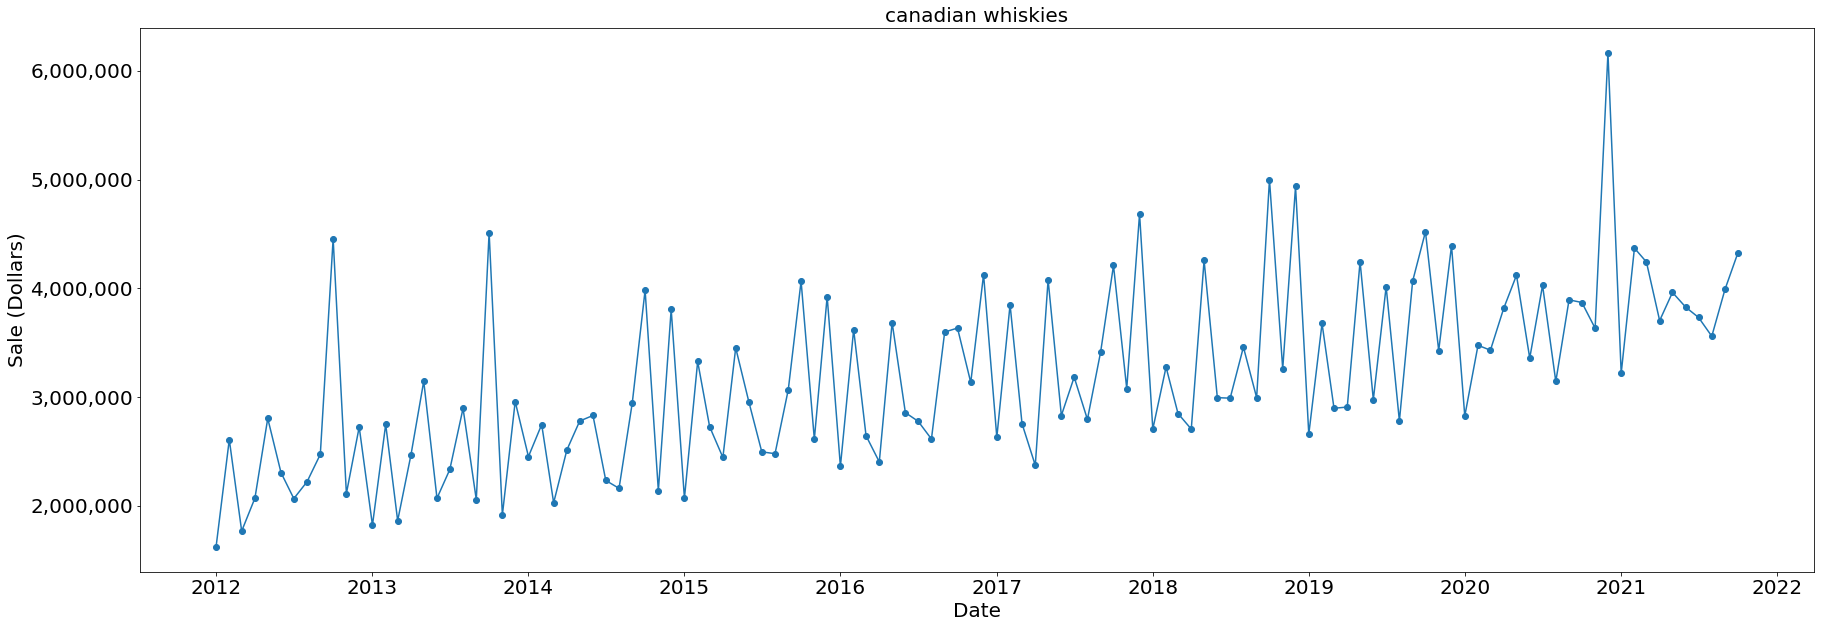

In [13]:
# Time series plot

data = S1['Sale (Dollars)'].resample('M').sum()

x = data.index.to_timestamp()
y = data.values

#pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S.%f')

#y.plot(figsize=(30,10), color='blue').set_title(cat)
fig,ax = plt.subplots(figsize=(30,10))

plt.plot(x,y, marker='o')

# Labelling 
fmt = lambda x, pos: '{:,.0f}'.format((x), pos)
ax.yaxis.set_major_formatter(fmt)
# Display
plt.xlabel("Date", size=20)
plt.ylabel("Sale (Dollars)",size=20)
plt.title(cat, size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

<AxesSubplot:xlabel='Date'>

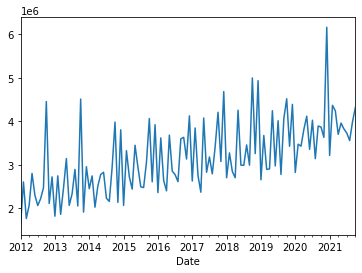

In [14]:
data.plot()

### ARIMA

In [15]:

# Parameter Tuning
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3845.21549742021
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3393.6318474587615
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3036.001814180894
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2694.2878995889737
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3051.781533987032
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3028.297606213314
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2723.25544929843
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2695.562268444651
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3752.487433651249
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3338.059698224348
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3008.5123442899426
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2667.774778306672
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3385.086051332434
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3323.27106925787
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2725.2755162895673
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2657.804908269375
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3553.627047521783
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3140.746650808889
ARIMA(0, 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3093      0.196     -1.580      0.114      -0.693       0.074
ar.L2          0.0260      0.186      0.140      0.889      -0.339       0.391
ar.L3          0.1406      0.180      0.783      0.434      -0.211       0.493
ma.L1         -0.7940      0.120     -6.616      0.000      -1.029      -0.559
ma.S.L12      -0.3904      0.149     -2.623      0.009      -0.682      -0.099
sigma2      2.081e+11   4.71e-13   4.42e+23      0.000    2.08e+11    2.08e+11


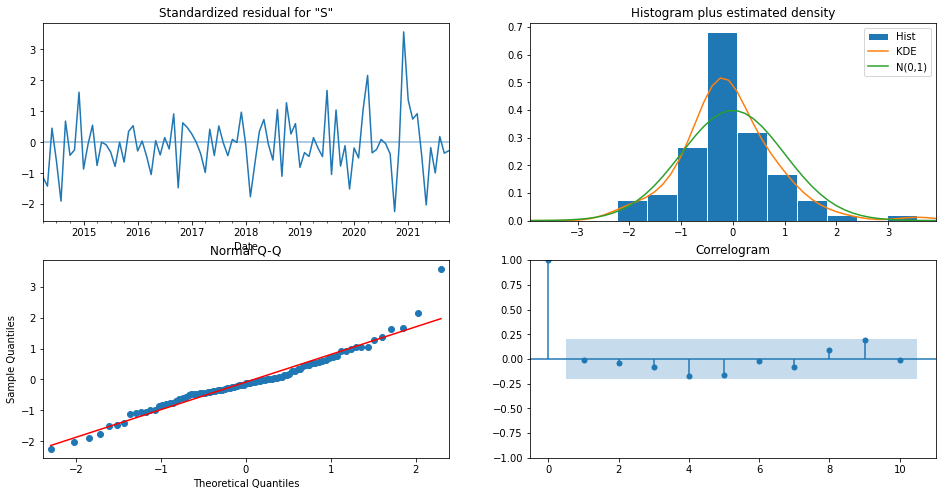

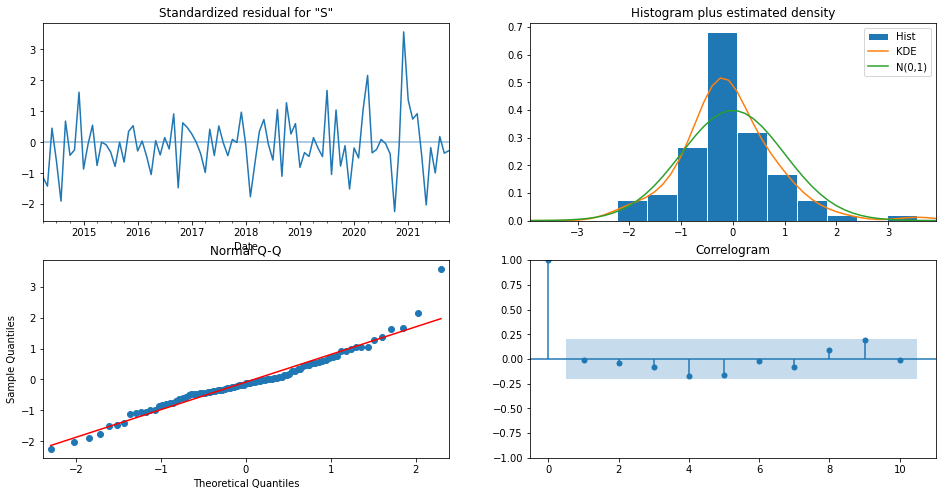

In [16]:
# Fitting Model
mod = sm.tsa.statespace.SARIMAX(data,
                                order = (3,1,1),
                                seasonal_order = (0,1,1,12),
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit(disp=False)
print(results.summary().tables[1])

results.plot_diagnostics(figsize = (16,8))

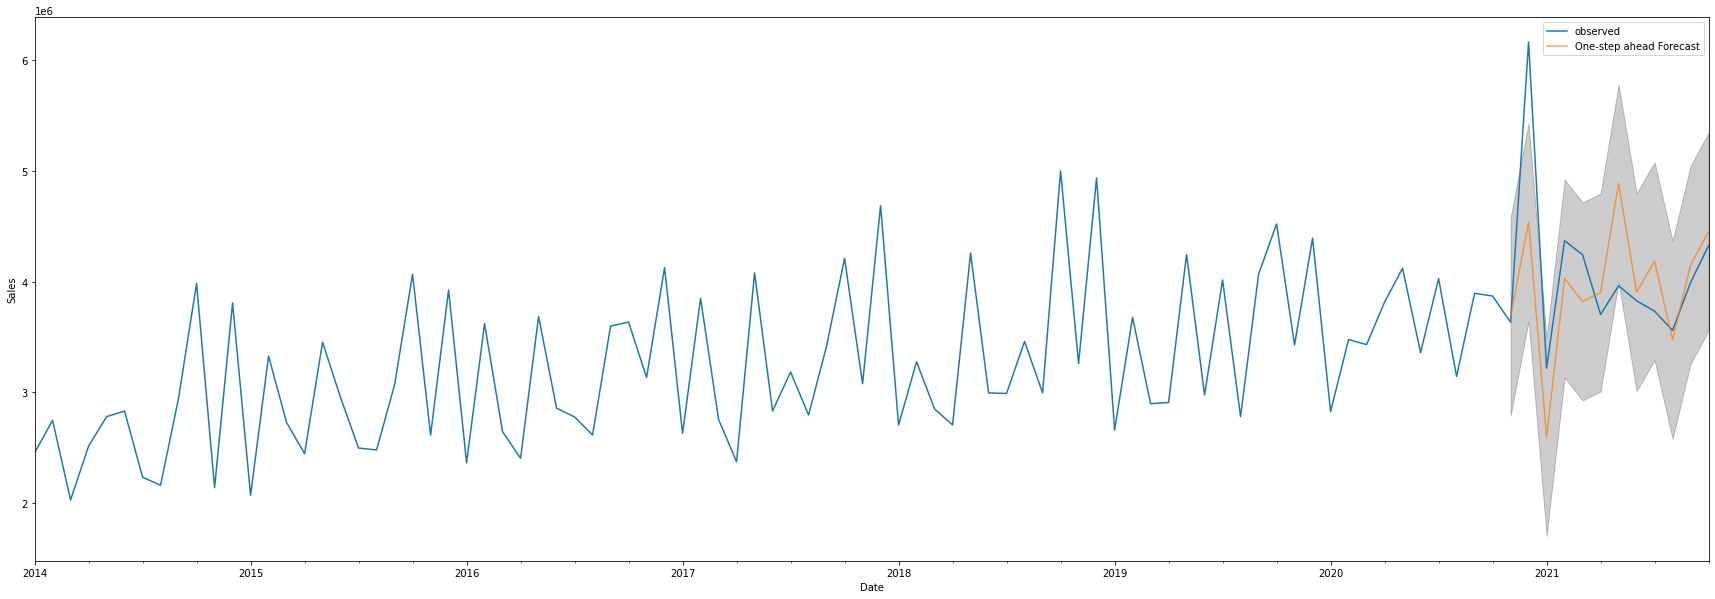

In [17]:
# Validation
# data is the original series

pred = results.get_prediction(start=pd.to_datetime('2020-11-01'), dynamic=False)
pred_ci = pred.conf_int()

fig,ax = plt.subplots(figsize=(30,10))

ax = data['2014':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [18]:
y_forecasted = pred.predicted_mean
y_truth = data['2020-11-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
print('R2 Value:',   r2_score(y_forecasted, y_truth))
print('MAPE Value:', mean_absolute_percentage_error(y_forecasted, y_truth))
print('MSE Value:',  mean_squared_error(y_forecasted, y_truth))

The Mean Squared Error of our forecasts is 373670524376.36
The Root Mean Squared Error of our forecasts is 611285.96
R2 Value: -0.20474722068161144
MAPE Value: 0.10554126709852195
MSE Value: 373670524376.3558


### Plot Arima Results

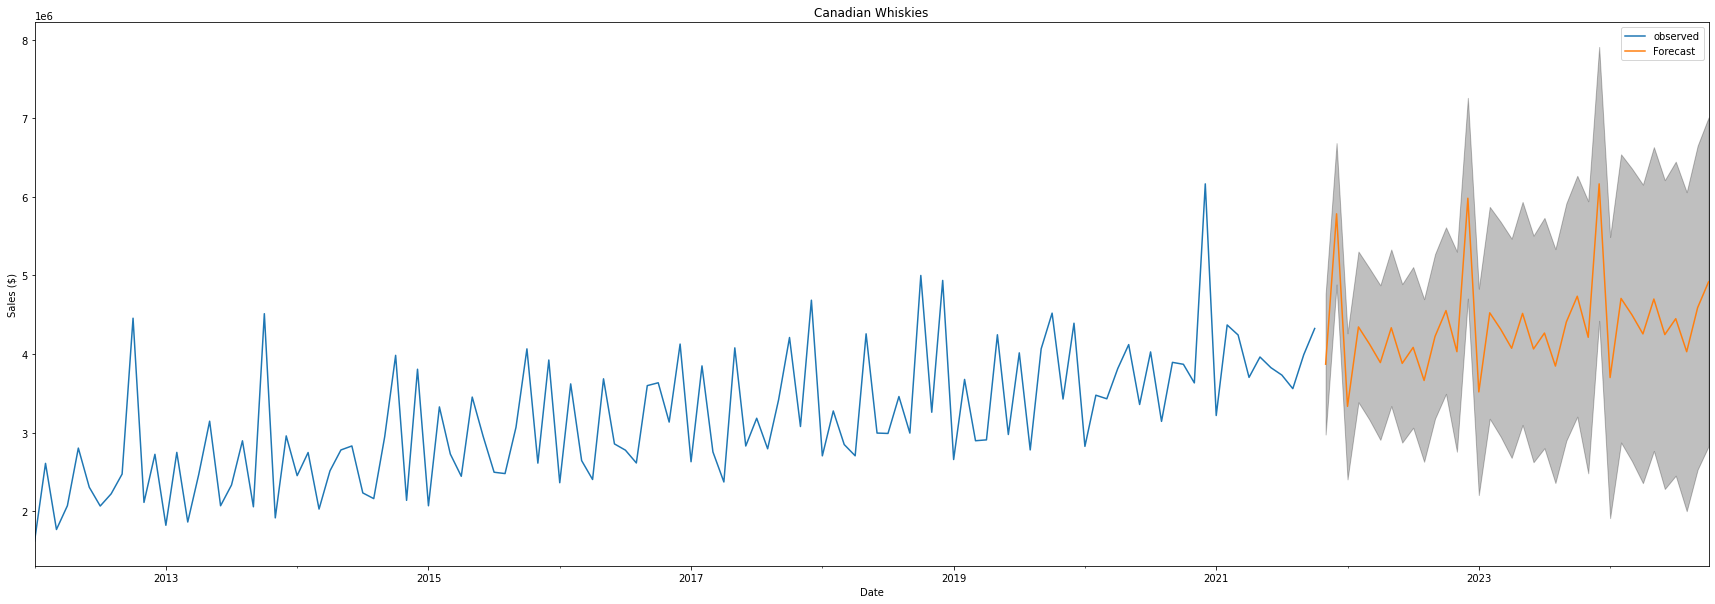

In [19]:
# Forecasting
fig,ax = plt.subplots(figsize=(30,10))
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = data.plot(label='observed')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Sales ($)')
ax.set_title('Canadian Whiskies')
plt.legend()

######################################################
### Forecasting with Prophet
######################################################

In [28]:
S1

,Sale (Dollars),Volume Sold (Liters)
Date,,
2012-01,1619928.13,129605.65
2012-02,2608526.27,234011.37
2012-03,1767241.10,136547.98
2012-04,2070353.37,164352.08
2012-05,2802983.20,251168.24
...,...,...
2021-06,3825980.48,240893.46
2021-07,3731650.29,258720.90
2021-08,3558846.59,214650.35


In [31]:
S2 = S1.reset_index()
S2['Date'] =  S2['Date'].dt.to_timestamp()

In [41]:
## Forecasting with Prophet
S2 = S1.reset_index()
S2['Date'] =  S2['Date'].dt.to_timestamp()

S3 = S2.rename(columns = {'Date': 'ds', 'Sale (Dollars)': 'y'})
S3_model = Prophet(interval_width = 0.95)
S3_model.fit(S3)


S3_forecast = S3_model.make_future_dataframe(periods=0, freq = 'MS')
S3_forecast = S3_model.predict(S3_forecast)



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [42]:
S3_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,2.321804e+06,9.575638e+05,2.376598e+06,2.321804e+06,2.321804e+06,-6.802078e+05,-6.802078e+05,-6.802078e+05,-6.802078e+05,-6.802078e+05,-6.802078e+05,0.0,0.0,0.0,1.641596e+06
1,2012-02-01,2.336622e+06,1.926385e+06,3.305359e+06,2.336622e+06,2.336622e+06,2.498417e+05,2.498417e+05,2.498417e+05,2.498417e+05,2.498417e+05,2.498417e+05,0.0,0.0,0.0,2.586463e+06
2,2012-03-01,2.350483e+06,1.190959e+06,2.625833e+06,2.350483e+06,2.350483e+06,-4.266773e+05,-4.266773e+05,-4.266773e+05,-4.266773e+05,-4.266773e+05,-4.266773e+05,0.0,0.0,0.0,1.923806e+06
3,2012-04-01,2.365301e+06,1.310372e+06,2.645512e+06,2.365301e+06,2.365301e+06,-4.020234e+05,-4.020234e+05,-4.020234e+05,-4.020234e+05,-4.020234e+05,-4.020234e+05,0.0,0.0,0.0,1.963278e+06
4,2012-05-01,2.379641e+06,2.166160e+06,3.494667e+06,2.379641e+06,2.379641e+06,4.695376e+05,4.695376e+05,4.695376e+05,4.695376e+05,4.695376e+05,4.695376e+05,0.0,0.0,0.0,2.849179e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2021-06-01,3.965350e+06,3.035978e+06,4.414710e+06,3.965350e+06,3.965350e+06,-2.786442e+05,-2.786442e+05,-2.786442e+05,-2.786442e+05,-2.786442e+05,-2.786442e+05,0.0,0.0,0.0,3.686706e+06
114,2021-07-01,3.979687e+06,3.116296e+06,4.427076e+06,3.979687e+06,3.979687e+06,-2.072502e+05,-2.072502e+05,-2.072502e+05,-2.072502e+05,-2.072502e+05,-2.072502e+05,0.0,0.0,0.0,3.772436e+06
115,2021-08-01,3.994501e+06,2.946241e+06,4.237123e+06,3.994501e+06,3.994501e+06,-3.945150e+05,-3.945150e+05,-3.945150e+05,-3.945150e+05,-3.945150e+05,-3.945150e+05,0.0,0.0,0.0,3.599986e+06
116,2021-09-01,4.009316e+06,3.333128e+06,4.676215e+06,4.009316e+06,4.009316e+06,2.310802e+04,2.310802e+04,2.310802e+04,2.310802e+04,2.310802e+04,2.310802e+04,0.0,0.0,0.0,4.032424e+06


Text(0.5, 1.0, 'Forecast Canadian Whisky')

<Figure size 1296x432 with 0 Axes>

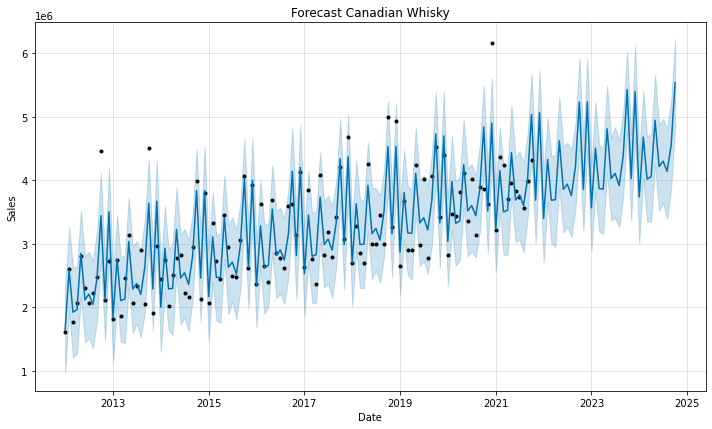

In [34]:
plt.figure(figsize=(18,6))
S3_model.plot(S3_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Forecast Canadian Whisky')

In [38]:
S3['y']

0      1619928.13
1      2608526.27
2      1767241.10
3      2070353.37
4      2802983.20
          ...    
113    3825980.48
114    3731650.29
115    3558846.59
116    3990895.26
117    4324345.01
Name: y, Length: 118, dtype: float64

In [43]:

print('R2 Value:',   r2_score(S3_forecast.loc[:, 'yhat'], S3['y']))

R2 Value: 0.7842837924952452


In [ ]:
####################################### XGBOOST

In [ ]:
lag = 4 # 3 meses
ahead = 1

In [ ]:
cat = 'canadian whiskies'
S1 = df[df['Category Name'] == cat]

S1.isnull().sum()
S1 = S1.groupby(pd.Grouper(freq='w'))['Sale (Dollars)','Volume Sold (Liters)'].sum().reset_index()
#S1 = S1.set_index('Date').to_perid('w')

In [ ]:
S1

In [ ]:
# Time series plot

#data = S1['Sale (Dollars)'].resample('w').sum()


#x = data.index.to_timestamp()
x = S1['Date']
y = S1['Sale (Dollars)']

#pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S.%f')

#y.plot(figsize=(30,10), color='blue').set_title(cat)
fig,ax = plt.subplots(figsize=(30,10))

plt.plot(x,y, marker='o')

# Labelling 
fmt = lambda x, pos: '{:,.0f}'.format((x), pos)
ax.yaxis.set_major_formatter(fmt)
# Display
plt.xlabel("Date", size=20)
plt.ylabel("Sale (Dollars)",size=20)
plt.title(cat, size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
S2 = S1.drop(columns=['Volume Sold (Liters)']).reset_index()
print('Number of steps (shape)', S2.shape)
# we create a numpy array with all the steps
prices = S2[['Sale (Dollars)']].to_numpy()

In [ ]:
s = prices
lvect = []

trainsize = len(s)
lvect = []
lvect2 = []
for i in range(lag, trainsize-lag-ahead):
   lvect.append(s[i:i+lag])
   lvect2.append(s[i+ahead+lag])   
X = np.stack(lvect, axis=1)
y = np.stack(lvect2, axis=1)
y = np.swapaxes(y, 1, 0)
X = np.swapaxes(X, 0, 1)
X = np.squeeze(X)
y = np.squeeze(y)

In [ ]:
# Split Train and Test
len_series = len(X)
cut = int(len_series*0.8)
train_x = X[:cut,:]
test_x  = X[cut:len_series,:]

train_y = y[:cut]
test_y  = y[cut:len_series]

In [ ]:
print("=========== SHAPE INPUT-OUTPUT MATRIXES =====================")
print("shape x_training :", train_x.shape, " y_training: : ", train_y.shape)
print("shape x_test     : ", test_x.shape, " y_test      : ", test_y.shape)
print("=============================================================")

In [ ]:
XGB = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.11, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=1, n_estimators=100,
       n_jobs=1, nthread=None, random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

XGB.fit(train_x, train_y)
y_hat = XGB.predict(test_x)

print('R2 Value:',   r2_score(test_y, y_hat))
print('MAPE Value:', mean_absolute_percentage_error(test_y, y_hat))

In [ ]:
y_hat

In [ ]:
# Time series plot


x = [x for x in range(0,len(test_y))]
y = test_y
y1 = y_hat

#pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S.%f')

#y.plot(figsize=(30,10), color='blue').set_title(cat)
fig,ax = plt.subplots(figsize=(30,10))

plt.plot(x,y, marker='o')
plt.plot(x,y1, color='r')

# Labelling 
fmt = lambda x, pos: '{:,.0f}'.format((x), pos)
ax.yaxis.set_major_formatter(fmt)
# Display
plt.xlabel("Date", size=20)
plt.ylabel("Sale (Dollars)",size=20)
plt.title(cat, size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
y

In [ ]:
#########################################

In [ ]:
stop

In [ ]:
#from sklearn.model_selection import TimeSeriesSplit
#ts_cv = TimeSeriesSplit(n_splits=2, max_train_size=len(y)*0.8,
#   test_size=len(y)*0.2)
year = 2021
train = y.dt.year == year
test =  y.dt.year != year



In [ ]:
# SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(y, order=(2, 1, 1), seasonal_order=(2, 0, 1, 12)) # parameters from auto arima
SARIMAX = model.fit(disp=False)
#SARIMAX.summary()

In [ ]:
# Prediction
start = len(train) - 1
end = len(train) + len(test) - 2
pred = SARIMAX.predict(start, end).rename('SARIMA pred'); pred

In [ ]:
series = y
window=12

import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error

green = sns.color_palette("deep", 8)[2]
blue = sns.color_palette("deep", 8)[0]

rolling_mean = series.rolling(window=window).mean()


fig,ax = plt.subplots(figsize=(17,8))
plt.title('Moving Average Model for sales',fontsize=15)
plt.plot(rolling_mean, color=green, label='Rolling mean trend')

#Plot confidence intervals for smoothed values
mae = mean_absolute_error(series[window:], rolling_mean[window:])
deviation = np.std(series[window:] - rolling_mean[window:])
lower_bound = rolling_mean - (mae + 1.92 * deviation)
upper_bound = rolling_mean + (mae + 1.92 * deviation)

plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
plt.plot(lower_bound, 'r--')

plt.plot(series[window:], color=blue,label='Actual values')

plt.legend(loc='best')
plt.grid(True)
#plt.xticks([])
plt.show()

In [ ]:
S1

In [ ]:
fit1 = ExponentialSmoothing(S1["Sale (Dollars)"]).fit(smoothing_level=0.1, optimized=False)
fit2 = ExponentialSmoothing(S1["Sale (Dollars)"]).fit(smoothing_level=0.5, optimized=False)

forecast1 = fit1.forecast(3).rename(r'$\alpha=0.1$')
forecast2 = fit2.forecast(3).rename(r'$\alpha=0.9$')

plt.figure(figsize=(17,8))

forecast1.plot(color='blue', legend=True)
forecast2.plot(color='red', legend=True)
S1["Sale (Dollars)"].plot(marker='',color='green', legend=True)
plt.ylabel("Sales", fontsize=15)

fit1.fittedvalues.plot(color='blue')
fit2.fittedvalues.plot(color='red')

plt.title("Exponential Smoothing for Retail Data", fontsize=15)
#plt.xticks([], minor=True)
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error,r2_score
import pandas as pd

X = S1["Sale (Dollars)"].values

l = len(S1)
train_size = 100
test_size = 18

train, test = X[0:train_size], X[train_size:train_size+test_size]

history = [x for x in train]
predictions = []
for t in range(len(test)):
	model = ARIMA(history, order=(3,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

mse = mean_squared_error(test, predictions)
R2 = r2_score(test,predictions)
print(f"MSE error: {mse}")
print(f"R2 error: {R2}")
plt.figure(figsize=(17,8))

plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA fit Weather Data")
#plt.xticks([])
plt.show()


In [ ]:
stop